In [185]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6 as ds
from copy import copy as dup
from scipy.integrate import odeint

# Graphics parameters
%matplotlib notebook
ticklabelsize = 15
fontsize = 20
linewidth = 2
fignum = 0

In [186]:
# Message
Nbar = 1.0 # new Nbar from VMD, 260K
#Nstar = .9/(2*np.pi)
Nstar = .55/(2*np.pi)

# Number of iterations to calculate Nliq from Ntot
niter = 1



In [187]:
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth

print 'max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec'
print 'min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec'

Estgrowthrate = deprate*(2*sigmastepmax-sigma0)/2
print 'estimated growth rate =', Estgrowthrate*umpersec_over_mlyperus, 'um/sec'
Esttau = 1/Estgrowthrate
print 'estimated tau =', Esttau, 'us'
nt = 101
deltat_0d = Esttau/nt
print 'dt =', deltat_0d, 'us'
deprate_times_deltaT = deprate * deltat_0d


max growth rate = 9.8 um/sec
min growth rate = 0.49 um/sec
estimated growth rate = 5.145 um/sec
estimated tau = 58.3090379009 us
dt = 0.577317206939 us


<IPython.core.display.Javascript object>


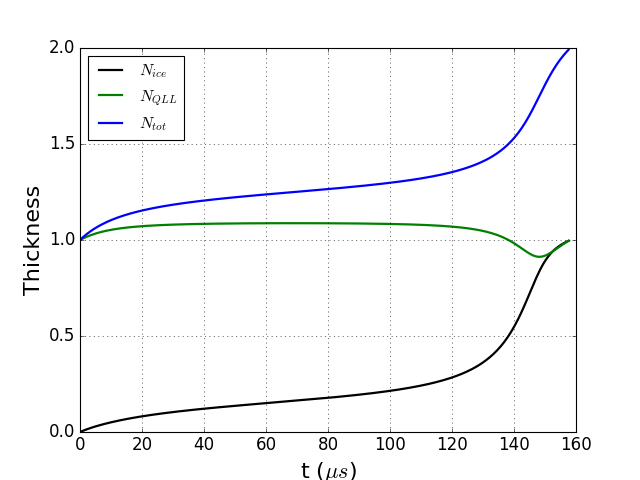

number of steps 273
tau 157.607597494
last Nice 0.995996290971


In [188]:
# This is the 0-d run

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastepmax, sigma0, deprate]

# Initial conditions for ODE solver
y0 = [Nbar, Nbar]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat_0d]

# Initialize the keeper arrays
tkeep_0d = [t0]
ykeep_0d = [y0]
tlast = dup(t0)

# Call the ODE solver
counter = 0
layer = 0
updatingFliq = True
layermax_0d = 1.0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat_0d
    Fliqlast, Ntotlast = dup(ylast)
    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter)
        ylast[0] = dup(Fliqlast)
    Nicelast = Ntotlast - Fliqlast

    # See whether to break
    if Nicelast > layermax_0d:
        break

    # Stuff into keeper arrays
    counter += 1
    ykeep_0d.append(ylast)
    tkeep_0d.append(tlast)
    
# Convert results to a numpy array
ykeep_0darr = np.array(ykeep_0d, np.float64)
tkeep_0darr = np.array(tkeep_0d, np.float64)

# Pack into separate arrays
Fliq = dup(ykeep_0darr[:,0])
Ntot = dup(ykeep_0darr[:,1])
Nice = Ntot-Fliq

# Save separate copies
Fliq0 = dup(Fliq)
Nice0 = dup(Nice)
Ntot0 = dup(Ntot)

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0d,Nice,lw=linewidth,color='k')
plt.plot(tkeep_0d,Fliq,lw=linewidth,color='g')
plt.plot(tkeep_0d,Ntot,lw=linewidth,color='b')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Thickness',fontsize=fontsize)
plt.legend([r'$N_{ice}$',r'$N_{QLL}$',r'$N_{tot}$'],loc='upper left')
plt.grid('on')

# Growth statistics
# delta_Ntot_0d = Ntotlast0-Ntotlast_start
# growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
# growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
# print  "0-D Modeled growth rate, um/s", growthrate_0d
# print  "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus
# alpha_0d = growthrate_0d/nu_kin/sigmastepmax
# print  "0-D Modeled alpha", alpha_0d
print "number of steps", counter
tau = dup(tkeep_0darr[-1])
print "tau", tau
print 'last Nice', Nice[-1]

In [189]:
# Spatial dependence
nx = counter+1; print 'nx', nx
xmax = 2.5
x = np.linspace(0, xmax, nx)
deltaX = x[1]-x[0]
sigmastep = np.ones(len(x))*sigmastepmax

nx 274


In [190]:
# Number of time steps
nt_onecycle = 100

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond
D /= 2 # micrometers^2/microsecond

# Time step constraints for the 1-d run
dtmaxtimefactor = 2
dtmax = deltaX**2/D; print 'dtmax', dtmax

# Actual time step for 1-d run
deltat_1d = tau/nt_onecycle; 
print 'dt', deltat_1d
print 'Steps for 1 cycle', tau/deltat_1d

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2


dtmax 0.838599739699
dt 1.57607597494
Steps for 1 cycle 100.0


In [191]:
# This is the 1-d run over one cycle

def propagate(nt,fignum=1,everythisstep=0,trajflag=True):

    # Flag for explicit updating Fliq(Ntot) every step
    updatingFliq = True

    # Bundle parameters for ODE solver
    params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

    # Initial conditions for ODE solver
    y0 = list((Fliq0,Ntot0))
    ylast = dup(y0)

    # Time steps
    t0 = 0.0
    tlast = dup(t0)
    ttot = 0.0
    tinterval = [t0, deltat_1d]

    # Initialize the keeper arrays
    tkeep = [dup(t0)]
    Nicekeep = [dup(Nice0)]
    Ntotkeep = [dup(Ntot0)]
    Fliqkeep = [dup(Fliq0)]

    # Graphics
    if everythisstep != 0:
        plt.figure(fignum)

    # Call the ODE solver
    lastlayer = 0
    lastdiff = 0
    for i in range(0,nt+1):

        # Make some local copies, with possible updates to Fliq
        Fliq, Ntot = ylast
        if updatingFliq:
            Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
            ylast[0] = Fliq
        Nice = Ntot - Fliq

        # Graph
        if everythisstep != 0:
            if np.mod(i,everythisstep)==0:
                plt.plot(x,Nice,lw=linewidth,color='k')
                plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
                plt.ylabel(r'$N_{ice}$',fontsize=fontsize)
                plt.grid('on')
                print 'counter', i

        # Integrate up to next time step
        y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
        ylast = np.reshape(y[1],(2,nx))
        tlast += deltat_1d
        ttot += deltat_1d

        # Stuff into keeper arrays if requested
        if trajflag:
            Nicekeep.append(Nice)
            Ntotkeep.append(Ntot)
            Fliqkeep.append(Fliq)
            tkeep.append(ttot)
            
    return Fliqkeep, Nicekeep, Ntotkeep, tkeep


<IPython.core.display.Javascript object>


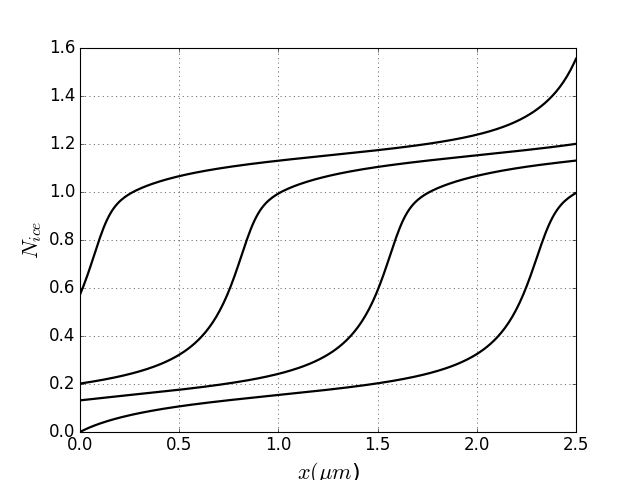

counter 0
counter 30
counter 60
counter 90


<IPython.core.display.Javascript object>


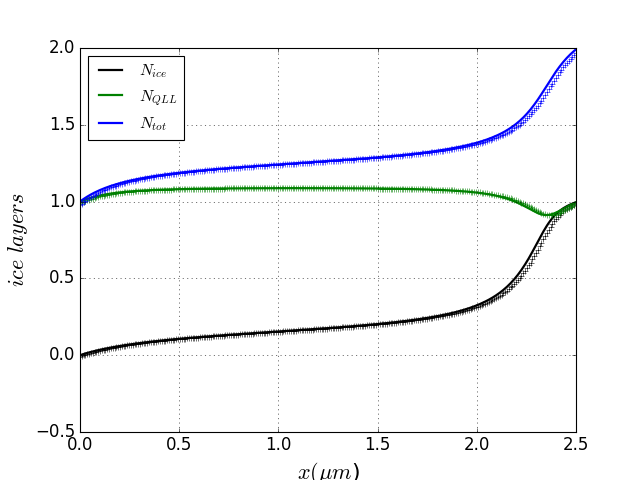

In [192]:
# Integrate over one cycle
fignum+=1; Fliqkeep, Nicekeep, Ntotkeep, tkeep = propagate(nt_onecycle, fignum, everythisstep=30)

# Checking: Plot first and last superimposed
fignum +=1
plt.figure(fignum)
plt.plot(\
         x, Nicekeep[0], 'k', \
         x, Fliqkeep[0], 'g', \
         x, Ntotkeep[0], 'b', \
         lw=linewidth)
plt.plot(\
         x, Nicekeep[-1]-1, 'k+', \
         x, Fliqkeep[-1], 'g+', \
         x, Ntotkeep[-1]-1, 'b+', \
         lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ layers$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend([r'$N_{ice}$',r'$N_{QLL}$',r'$N_{tot}$'],loc='upper left')
plt.grid('on')


In [193]:
Fliqkeep, Nicekeep, Ntotkeep, tkeep = propagate(nt_onecycle*20)


<IPython.core.display.Javascript object>


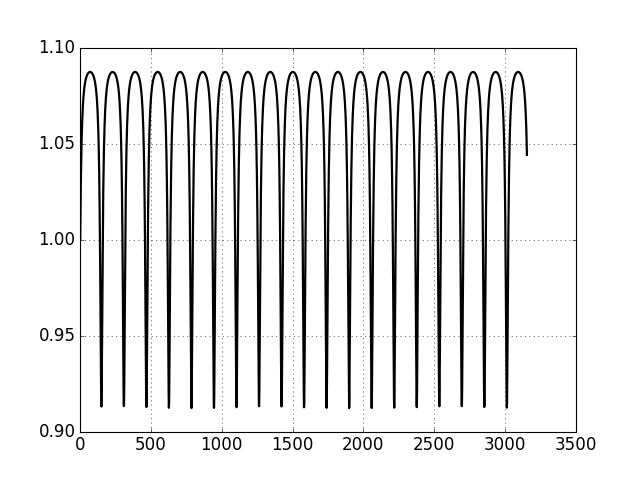

In [194]:
Fliqkeeparr = np.array(Fliqkeep)
fignum +=1
plt.figure(fignum)
plt.plot(\
         tkeep, Fliqkeeparr[:,0], 'k', \
         lw=linewidth)
plt.grid('on')

In [195]:
# # Saving these results to file
# print Nice[0]
# if Nice[0] > 100000:
#     Nice -= 100000
# if Save_new_file:
#     print "saving to", nextfile
#     np.savez_compressed(nextfile, Nice=Nice, Fliq=Fliq, 
#                         x=x, t=ttot,
#                         Nbar=Nbar, Nstar=Nstar,
#                         sigma0=sigma0, c_r=c_r, D=D, L=L, 
#                         nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
#                         sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


In [196]:
# if trajflag:
#     print "saving to", trajfile
#     np.savez_compressed(trajfile, Nice=Nicekeep, Fliq=Fliqkeep,
#                         x=x, t=tkeep, 
#                         Nbar=Nbar, Nstar=Nstar,
#                         sigma0=sigma0, c_r=c_r, D=D, L=L, 
#                         nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
#                         sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


In [197]:
# if traj0flag:
#     print "saving to", traj0file
#     np.savez_compressed(traj0file, ykeep_0Darr=ykeep_0Darr,
#                         x=x, tkeep_0D=tkeep_0D,  
#                         sigma0=sigma0, c_r=c_r, D=D, L=L, 
#                         nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
#                         sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle,
#                         dtmaxtimefactor = dtmaxtimefactor,
#                         deltaT = deltaT)
